<ipython-input-1-f48a558583ed>:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  brent = pd.read_csv(
<ipython-input-1-f48a558583ed>:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  wti = pd.read_csv(


XGBoost MAE (Brent-WTI Spread): 0.83


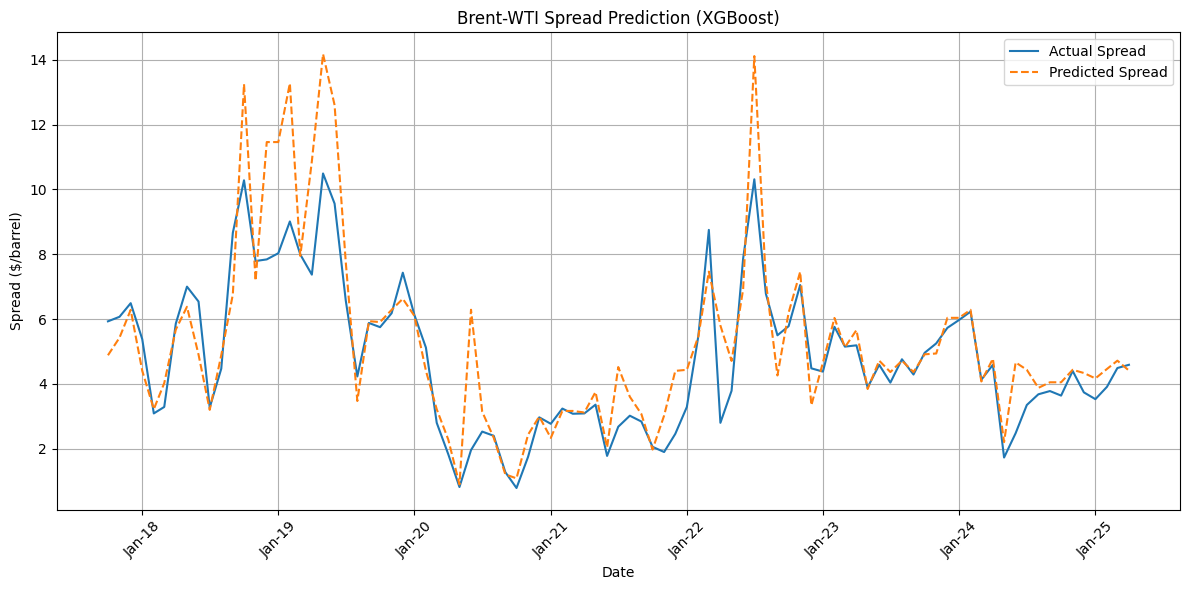


Feature Importances:
Spread_Lag1: 0.786
Spread_Pct_Change: 0.030
Spread_MA5: 0.184


In [1]:
# Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.dates as mdates

# Step 2: Load Brent and WTI spot prices from GitHub with date parsing fixed
brent_url = 'https://raw.githubusercontent.com/blainehodder/Blaine_AI_Projects/refs/heads/main/brent.csv'
wti_url = 'https://raw.githubusercontent.com/blainehodder/Blaine_AI_Projects/refs/heads/main/wti.csv'

brent = pd.read_csv(
    brent_url,
    index_col='Date',
    date_parser=lambda x: pd.to_datetime(x, format='%b-%y', errors='coerce')
)
wti = pd.read_csv(
    wti_url,
    index_col='Date',
    date_parser=lambda x: pd.to_datetime(x, format='%b-%y', errors='coerce')
)

# Step 3: Rename and merge
brent.rename(columns={'Price': 'Brent'}, inplace=True)
wti.rename(columns={'Price': 'WTI'}, inplace=True)
df = brent.join(wti, how='inner')
df.dropna(inplace=True)
df = df.sort_index()

# Step 4: Feature engineering
df['Spread'] = df['Brent'] - df['WTI']
df['Spread_Lag1'] = df['Spread'].shift(1)
df['Spread_Pct_Change'] = df['Spread'].pct_change()
df['Spread_MA5'] = df['Spread'].rolling(window=5).mean()
df.dropna(inplace=True)

# Step 5: Define features and target
X = df[['Spread_Lag1', 'Spread_Pct_Change', 'Spread_MA5']]
y = df['Spread']

# Step 6: Train/test split
split = int(0.8 * len(df))
train = df.iloc[:split]
test = df.iloc[split:]

X_train = train[['Spread_Lag1', 'Spread_Pct_Change', 'Spread_MA5']]
y_train = train['Spread']

X_test = test[['Spread_Lag1', 'Spread_Pct_Change', 'Spread_MA5']]
y_test = test['Spread']

# Step 7: Train XGBoost model
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)

# Step 8: Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost MAE (Brent-WTI Spread): {mae:.2f}")

# Step 9: Plot predictions
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Spread')
plt.plot(y_test.index, y_pred, label='Predicted Spread', linestyle='--')
plt.title('Brent-WTI Spread Prediction (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Spread ($/barrel)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.tight_layout()
plt.show()

# Step 10: Feature importances
feature_names = X.columns
importances = model.feature_importances_

print("\nFeature Importances:")
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.3f}")
